In [2]:
# ----------------------------
# Make Tables and Figures for the GCBM estimations on DOM pools
# ----------------------------

if(!require(tidyverse)){install.packages("tidyverse")}
if(!require(RSQLite)){install.packages("RSQLite")}
if(!require(writexl)){install.packages("writexl")}
library(tidyverse) 
library(RSQLite) 
library(writexl) 

# Avoid scientific notation
options(scipen=10000)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.2.1     ✔ stringr 1.4.1
✔ purrr   1.0.1     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: RSQLite

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘RSQLite’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plogr’


Loading required package: writexl

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘writexl’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is 

In [7]:
# List the directories of the different GCBM runs
# Here only one directory is listed, but mode than one can be made to make a sensitivity analysis
# e.g. runs <- c('../Standalone_GCBM','../Standalone_GCBM_decaymod','../Standalone_GCBM_turnovermod')
runs <- c('Standalone_GCBM')

In [8]:
# Make a named vector to point the name you want each run to have in the graph
# Here only one name is listed, but mode than one can be made to make a sensitivity analysis
# e.g. names_runs <- c('Default','Modified Decay parameters',Modified Decay, Turnover and Spinup parameters')
names_runs <- c('Default Decay, Turnover and Spinup parameters')
names_runs <- c('Standalone_GCBM' = 'Default Decay, Turnover and Spinup parameters')

In [9]:
#Loop though the runs
for (run in runs) {
  
  # Path to the database
  path_db<-paste0(run,"/processed_output/compiled_gcbm_output.db")
  #----------------------
  
  # Connect to the database
  conn <- dbConnect(RSQLite::SQLite(), path_db)
  
  # List the tables in the databases
  dbListTables(conn)
  
  # Pool indicators
  pool_ind<-dbGetQuery(conn, "SELECT * FROM v_pool_indicators")
  
  # Calculate the pools total carbon for forests per lifezone and year
  pools_run<-pool_ind %>% filter(indicator %in% c("Total Biomass","Deadwood","Litter","Soil Carbon")) %>% 
    group_by(year,indicator,LifeZone) %>% 
    summarize(pool_tc_sum=sum(pool_tc)) 


  # Get the areas for each lifezone
  age_ind<-dbGetQuery(conn, "SELECT * FROM v_age_indicators")
  areas_run<-age_ind %>%  
    group_by(year,LifeZone) %>% 
    summarize(area_sum=sum(area)) %>% 
    ungroup()
  
  # Divide the DOM values per area to obtain ton/ha values
  pools_run_area <- left_join(pools_run,areas_run,by = c("year","LifeZone"))
  pools_run_area <- mutate(pools_run_area, pool_tc_per_ha = pool_tc_sum/area_sum)
  pools_run_area$run <- run
  
  # Recode the runs 
  pools_run_area$run <- as.character(recode(pools_run_area$run, !!!names_runs))
  
  # Make a compiled database
  if(exists("pools_full")){
    pools_full <- unique(rbind(pools_full,pools_run_area))
  } else {
    pools_full <- pools_run_area 
  }
  
  print(run)
  
  dbDisconnect(conn)


}

`summarise()` has grouped output by 'year', 'indicator'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


[1] "Standalone_GCBM"


In [10]:
# Check the recoding
unique(pools_full$run)

[1] "Default Decay, Turnover and Spinup parameters"

In [12]:
#Write full table
write_csv(pools_full,"Tables/Pools_DOM_Sensitivity_full.csv")

In [13]:
# Make a Table with the DOM stocks every 10 years, from 0 to 150 years old
pools_summary <- pools_full %>% 
  filter(year %in% seq(1900,2050,by=10)) %>% 
  mutate(Age = year - 1900) 

for (ag in unique(pools_summary$Age)) {
  
  # Make a pools table for that specific age (ag)
  pools_forest <- pools_summary %>% 
    filter(Age == ag) %>% 
    select(indicator,LifeZone,pool_tc_per_ha,run) %>% 
    pivot_wider(names_from = run,values_from = pool_tc_per_ha)
  
  # Write a table every 10 years
  write_csv(pools_forest,paste0("Tables/Pools_DOM_Sensitivity_forest_",ag,"_years.csv"))


}

Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`
Adding missing grouping variables: `year`


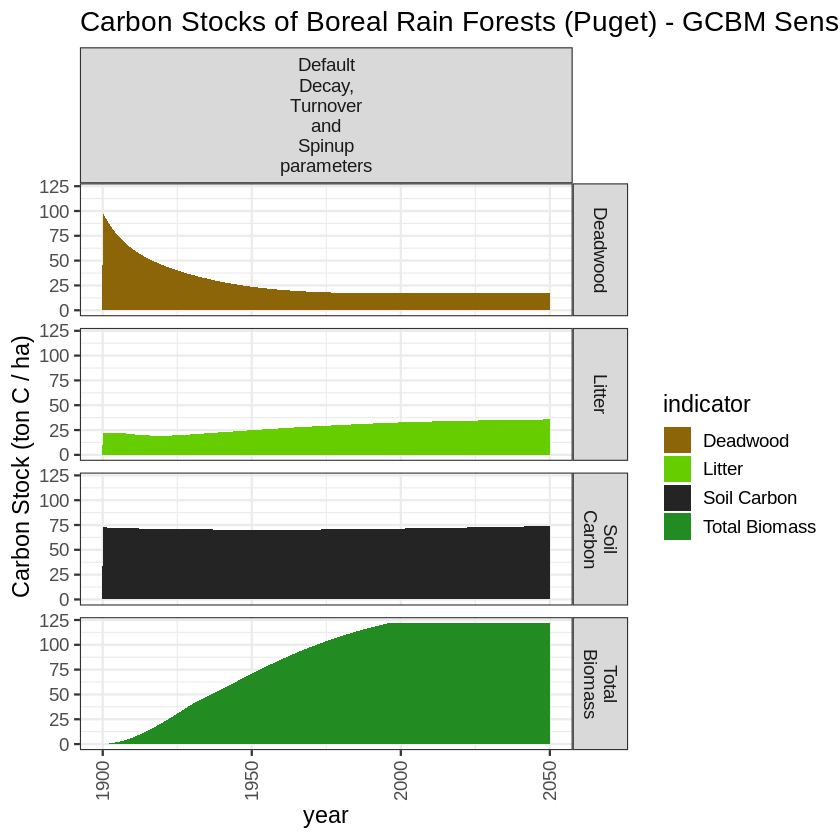

In [16]:
# Make figures for each life zone 


# Tropical dry
p <- ggplot(filter(pools_full, LifeZone=="Boreal rain forest"), aes(x = year, y = pool_tc_per_ha, fill = indicator))+
  geom_area() +
  facet_grid(indicator~run,labeller = label_wrap_gen(width = 7)) +
  ylab("Carbon Stock (ton C / ha)") +
  scale_fill_manual(values = c("darkgoldenrod4","chartreuse3","gray14","forestgreen")) +
  ggtitle("Carbon Stocks of Boreal Rain Forests (Puget) - GCBM Sensitivity analysis") +
  theme_bw(14) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


p

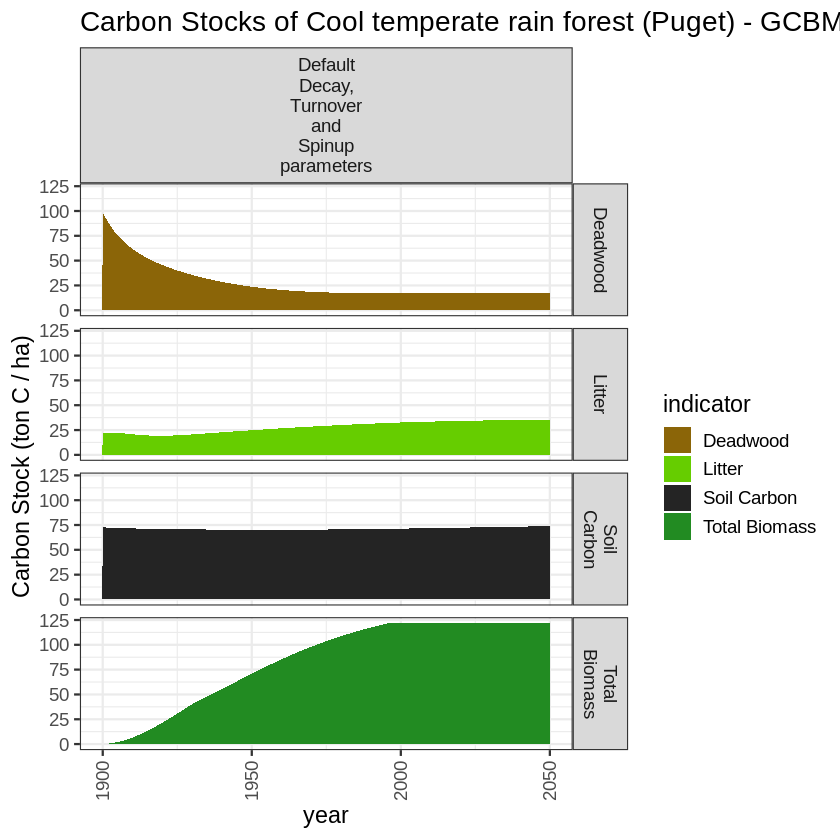

In [18]:
# Make figures for each life zone 


# Tropical dry
p <- ggplot(filter(pools_full, LifeZone=="Cool temperate rain forest"), aes(x = year, y = pool_tc_per_ha, fill = indicator))+
  geom_area() +
  facet_grid(indicator~run,labeller = label_wrap_gen(width = 7)) +
  ylab("Carbon Stock (ton C / ha)") +
  scale_fill_manual(values = c("darkgoldenrod4","chartreuse3","gray14","forestgreen")) +
  ggtitle("Carbon Stocks of Cool temperate rain forest (Puget) - GCBM Sensitivity analysis") +
  theme_bw(14) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


p

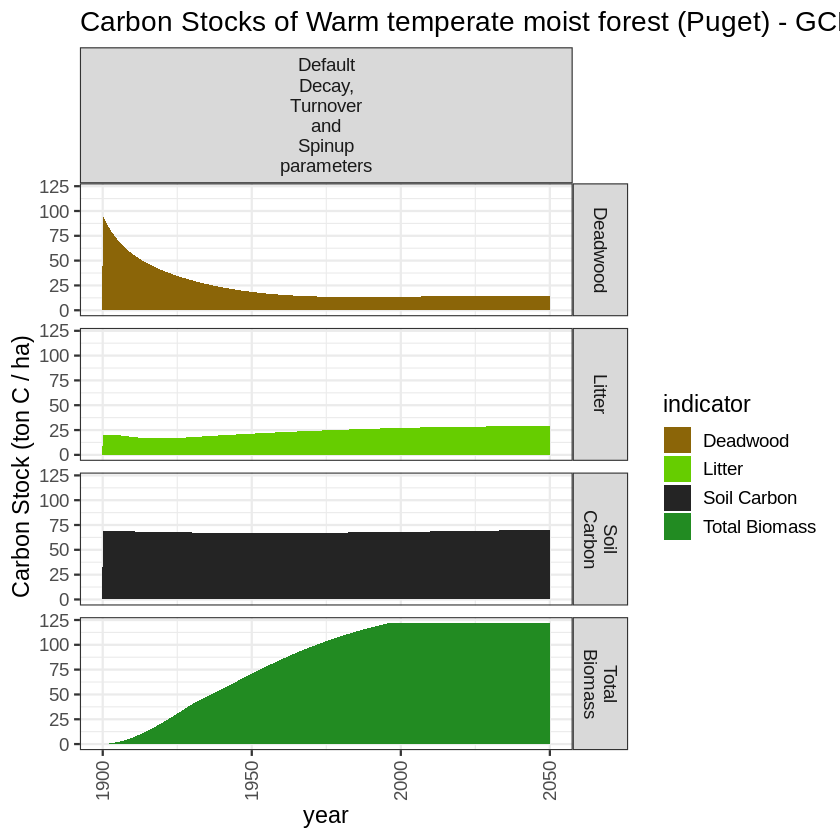

In [19]:
# Make figures for each life zone 


# Tropical dry
p <- ggplot(filter(pools_full, LifeZone=="Warm temperate moist forest"), aes(x = year, y = pool_tc_per_ha, fill = indicator))+
  geom_area() +
  facet_grid(indicator~run,labeller = label_wrap_gen(width = 7)) +
  ylab("Carbon Stock (ton C / ha)") +
  scale_fill_manual(values = c("darkgoldenrod4","chartreuse3","gray14","forestgreen")) +
  ggtitle("Carbon Stocks of Warm temperate moist forest (Puget) - GCBM Sensitivity analysis") +
  theme_bw(14) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


p